# <font color='gren'>Exercício 6

## **1-Imports Necessários**

In [2]:
import numpy as np
from numpy import random

import scipy
from scipy import linalg
from scipy.sparse import diags, linalg

import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

import time

import random

import math

## **2-Funções auxiliares**

* Função para plotar os curvas de nível constante de temperatura

In [3]:

def PlotaMembrane(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    im = ax.contourf(X, Y, Z, 20)
    im2 = ax.contour(X, Y, Z, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()
    
def PlotaSurface(N1,N2,L1,L2,W):
    x = np.linspace(0, L1, N1)
    y = np.linspace(0, L2, N2)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(W)
    ax = plt.axes(projection ='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set(xlabel='x', ylabel='y', title='Deslocamento vertical')
    ax.set_zlim(-1.01, 1.01)
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    

* Montagem das matrizes K e M modificada para densidade variável conforme o enunciado

In [4]:
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen(N1, N2, sigma, e, delta):
    nunk = N1*N2

    # Stiffness matrix K: Build it as a sparse matrix 
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3], [-N1, -1, 0, 1, N1], format='csr')

    # Force the eigenvalues associated to boundary points 
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')

    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]

    # Vetor de densidade "rho´s" (possui um valor para cada ponto [coordenada] da placa)
    p=np.array([])
    for i in range(N1):
        for j in range(N2):
            c=1+0.75*(math.cos(4*math.pi*i*delta)*math.sin(2*math.pi*j*delta))
            p=np.append(p,c)
    p=e*p

    # Mass matrix: Simple case, multiple of identity
    M = scipy.sparse.diags(p, format='csr')
    
    return K, M    

## **3-Resultados**

* Pré-setagem:

In [5]:
L1,L2=1,0.5
e=1
N1,N2=41,21
delta=L1/(N1-1)
K,M=BuildMatrizesEigen(N1,N2,1.0,1,delta)

* Cálculo de modos e frequências 

In [11]:
Lam,Q=scipy.sparse.linalg.eigsh(K, k=20, M=M, which='SM')
omega=np.sqrt(Lam)
print('\nFrequencias:', omega,'\n')


Frequencias: [ 6.95372825  8.95823938 11.12690189 13.43830866 14.69893635 15.57612159
 16.37596618 17.37171735 18.63708147 18.90099596 20.33769299 20.78786639
 21.34427188 22.21621758 22.39795775 23.47819732 24.27746153 24.60877939
 24.84455728 25.58258491] 



* Plotagem de Membrana


Modo escolhido: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.46042377e-04  1.51248245e-03
  3.62907299e-03  6.86884474e-03  1.08775499e-02  1.49533810e-02
  1.82554028e-02  2.00591429e-02  1.99664501e-02  1.80052777e-02
  1.45999618e-02  1.04339190e-02  6.25384268e-03  2.67438406e-03
  3.62832952e-05 -1.64722491e-03 -2.64595343e-03 -3.38650781e-03
 -4.2819

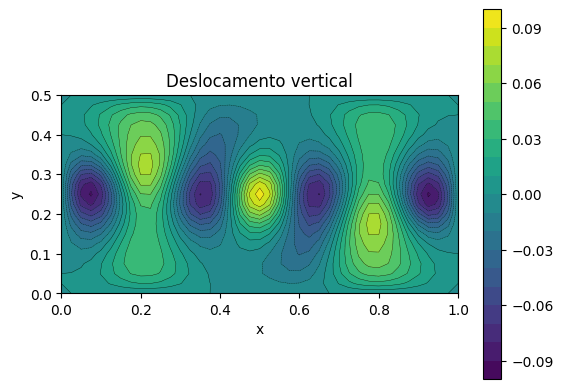

In [14]:
# Plotar Escolher um modo
k = 12
mode = Q[:,k] 
mode[np.where(np.abs(mode) < 1e-10)] = 0.0
print('\nModo escolhido:',mode)

Wplot = mode.reshape(N2,N1)
PlotaMembrane(N1,N2,L1,L2,Wplot)